In [ ]:
!pip install --upgrade geopandas
!pip install --upgrade pyshp
!pip install --upgrade shapely
!pip install --upgrade descartes
!pip install --upgrade psycopg2

Requirement already up-to-date: geopandas in /usr/local/lib/python3.6/dist-packages (0.7.0)
Requirement already up-to-date: pyshp in /usr/local/lib/python3.6/dist-packages (2.1.0)
Requirement already up-to-date: shapely in /usr/local/lib/python3.6/dist-packages (1.7.0)
Requirement already up-to-date: descartes in /usr/local/lib/python3.6/dist-packages (1.1.0)
     |████████████████████████████████| 389kB 2.8MB/s 
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess as sp
from shapely import wkt
import seaborn as sns
sns.set()
import requests
import json
import psycopg2

## ---------------------------------------------------------------------------------------
## Calling API to request the data
## ---------------------------------------------------------------------------------------

In [ ]:
url = "https://api.covid19api.com/all?from=2020-01-22T00:00:00Z&to=2020-06-16T00:00:00Z"

payload = {}
headers= {}

response = requests.request("GET", url, headers=headers, data = payload)

data = response.json()

with open('files/covid19.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)
    
data_from_json = pd.read_json('files/covid19.json')
data_from_json.to_csv("files/covid19.csv", index=False)

In [ ]:
corona_df = pd.read_csv("files/covid19.csv")

In [ ]:
corona_df.head()

,Country,CountryCode,Province,City,CityCode,Lat,Lon,Confirmed,Deaths,Recovered,Active,Date
0,Afghanistan,AF,NaN,NaN,NaN,33.94,67.71,0,0,0,0,2020-01-22 00:00:00+00:00
1,Afghanistan,AF,NaN,NaN,NaN,33.94,67.71,0,0,0,0,2020-01-23 00:00:00+00:00
2,Afghanistan,AF,NaN,NaN,NaN,33.94,67.71,0,0,0,0,2020-01-24 00:00:00+00:00
3,Afghanistan,AF,NaN,NaN,NaN,33.94,67.71,0,0,0,0,2020-01-25 00:00:00+00:00
4,Afghanistan,AF,NaN,NaN,NaN,33.94,67.71,0,0,0,0,2020-01-26 00:00:00+00:00


## ---------------------------------------------------------------------------------------
## Cleaning the Coronavirus dataframe
## ---------------------------------------------------------------------------------------

In [ ]:
# Dropping columns that are not needed
corona_df.drop(['Province', 'City', 'CityCode', 'Lat', 'Lon', 'CountryCode'], axis=1, inplace=True)

# Converting the Date column from float to datetime data-type
corona_df['Date'] =  pd.to_datetime(corona_df['Date'])
corona_df.Date = corona_df.Date.dt.date
corona_df['Date'] =  pd.to_datetime(corona_df['Date'])
corona_df.head()

,Country,Confirmed,Deaths,Recovered,Active,Date
0,Afghanistan,0,0,0,0,2020-01-22
1,Afghanistan,0,0,0,0,2020-01-23
2,Afghanistan,0,0,0,0,2020-01-24
3,Afghanistan,0,0,0,0,2020-01-25
4,Afghanistan,0,0,0,0,2020-01-26


In [ ]:
corona_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513336 entries, 0 to 513335
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Country    513336 non-null  object        
 1   Confirmed  513336 non-null  int64         
 2   Deaths     513336 non-null  int64         
 3   Recovered  513336 non-null  int64         
 4   Active     513336 non-null  int64         
 5   Date       513336 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 23.5+ MB


In [ ]:
# Some countries, such as China, are split into different provinces/states. 
# Since we just want the total number of cases per country, we get the sum for each country at each date:
sum_df = corona_df.groupby(['Country', 'Date'], as_index=False).sum()

In [ ]:
sum_df.head()

,Country,Date,Confirmed,Deaths,Recovered,Active
0,Afghanistan,2020-01-22,0,0,0,0
1,Afghanistan,2020-01-23,0,0,0,0
2,Afghanistan,2020-01-24,0,0,0,0
3,Afghanistan,2020-01-25,0,0,0,0
4,Afghanistan,2020-01-26,0,0,0,0


In [ ]:
sum_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27156 entries, 0 to 27155
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Country    27156 non-null  object        
 1   Date       27156 non-null  datetime64[ns]
 2   Confirmed  27156 non-null  int64         
 3   Deaths     27156 non-null  int64         
 4   Recovered  27156 non-null  int64         
 5   Active     27156 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 1.5+ MB


## ---------------------------------------------------------------------------------------
## Extracting the Dates
## ---------------------------------------------------------------------------------------

In [ ]:
# Extracting the date column from the dataframe
# This will come in handy later when merging dataframes on the date column, and when looping over the date to plot the map

date_list = pd.DataFrame(sum_df.Date.unique())
date_list.rename(columns = {0:'Date'}, inplace = True)
date_list = date_list.loc[date_list.Date <= sum_df.Date.max()]
date_list.reset_index(drop=True, inplace=True)
date_list.to_csv('date_list.csv', encoding='utf-8', index=False)

## ---------------------------------------------------------------------------------------
## Reading and cleaning the shape file
## ---------------------------------------------------------------------------------------

In [ ]:
# Shape file for plotting world maps
shape_file = gpd.read_file('shape_files/Countries_WGS84.shp')

In [ ]:
shape_file.head()

,OBJECTID,CNTRY_NAME,geometry
0,1,Aruba,"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
1,2,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
2,3,Afghanistan,"POLYGON ((61.27656 35.60725, 61.29638 35.62853..."
3,4,Algeria,"POLYGON ((-5.15213 30.18047, -5.13917 30.19236..."
4,5,Azerbaijan,"MULTIPOLYGON (((45.02583 41.03055, 45.00999 41..."


In [ ]:
# Dropping columns that are not needed
shape_file.drop('OBJECTID', axis=1, inplace=True)

# Renaming columns
shape_file.rename(columns = {'CNTRY_NAME':'Country'},
               inplace = True)

In [ ]:
shape_file.head()

,Country,geometry
0,Aruba,"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
1,Antigua and Barbuda,"MULTIPOLYGON (((-61.73889 17.54055, -61.75195 ..."
2,Afghanistan,"POLYGON ((61.27656 35.60725, 61.29638 35.62853..."
3,Algeria,"POLYGON ((-5.15213 30.18047, -5.13917 30.19236..."
4,Azerbaijan,"MULTIPOLYGON (((45.02583 41.03055, 45.00999 41..."


In [ ]:
shape_file.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Country   251 non-null    object  
 1   geometry  251 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 4.0+ KB


## ---------------------------------------------------------------------------------------
## Comparing and renaming the country names in Coronavirus dataframe
## ---------------------------------------------------------------------------------------

In [ ]:
# Making the country names match between the dataframe and the shapefile


sum_df = sum_df.replace({'Country' : 'Bahamas'}, 'Bahamas, The')
sum_df = sum_df.replace({'Country' : 'Belarus'}, 'Byelarus')
sum_df = sum_df.replace({'Country' : 'Brunei Darussalam'}, 'Brunei')
sum_df = sum_df.replace({'Country' : 'Congo (Kinshasa)'}, 'Congo')
sum_df = sum_df.replace({'Country' : 'Gambia'}, 'Gambia, The')
sum_df = sum_df.replace({'Country' : 'Iran, Islamic Republic of'}, 'Iran')
sum_df = sum_df.replace({'Country' : 'Korea (South)'}, 'South Korea')
sum_df = sum_df.replace({'Country' : 'Lao PDR'}, 'Laos')
sum_df = sum_df.replace({'Country' : 'Macedonia, Republic of'}, 'Macedonia')
sum_df = sum_df.replace({'Country' : 'Myanmar'}, 'Myanmar (Burma)')
sum_df = sum_df.replace({'Country' : 'Russian Federation'}, 'Russia')
sum_df = sum_df.replace({'Country' : 'Saint Kitts and Nevis'}, 'St. Kitts and Nevis')
sum_df = sum_df.replace({'Country' : 'Saint Lucia'}, 'St. Lucia')
sum_df = sum_df.replace({'Country' : 'Saint Vincent and Grenadines'}, 'St. Vincent and Grenadines')
sum_df = sum_df.replace({'Country' : 'Syrian Arab Republic (Syria)'}, 'Syria')
sum_df = sum_df.replace({'Country' : 'Taiwan, Republic of China'}, 'Taiwan')
sum_df = sum_df.replace({'Country' : 'United States of America'}, 'United States')
sum_df = sum_df.replace({'Country' : 'Venexuela (Bolivarian Republic)'}, 'Venezuela')
sum_df = sum_df.replace({'Country' : 'Viet Nam'}, 'Vietnam')

## ---------------------------------------------------------------------------------------
## Extracting the country names
## ---------------------------------------------------------------------------------------

In [ ]:
# Extracting the country column from the dataframe
# This will come in handy later when merging dataframes on the country column

country_list = pd.DataFrame(shape_file.Country.unique())
country_list.rename(columns = {0:'Country'}, inplace = True) 
country_list.to_csv('country_list.csv', encoding='utf-8', index=False)

## ---------------------------------------------------------------------------------------------
## Merging the Dates and Countries to form one single dataframe with all Countries and all Dates
## ---------------------------------------------------------------------------------------------

In [ ]:
# Merging the date and country dataframes such that the date from January to April is available for EACH country

def cartesian_product_simplified(left, right):
    la, lb = len(left), len(right)
    ia2, ib2 = np.broadcast_arrays(*np.ogrid[:la,:lb])

    return pd.DataFrame(
        np.column_stack([left.values[ia2.ravel()], right.values[ib2.ravel()]]))

country_date_list = cartesian_product_simplified(country_list, date_list)

In [ ]:
country_date_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36646 entries, 0 to 36645
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       36646 non-null  object
 1   1       36646 non-null  object
dtypes: object(2)
memory usage: 572.7+ KB


In [ ]:
# Renaming Columns
country_date_list.rename(columns = {0:'Country', 1:'Date'},
                          inplace = True)  

In [ ]:
country_date_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36646 entries, 0 to 36645
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Country  36646 non-null  object
 1   Date     36646 non-null  object
dtypes: object(2)
memory usage: 572.7+ KB


In [ ]:
# Coverting from float to datetime
country_date_list['Date'] = pd.to_datetime(country_date_list['Date'])

In [ ]:
country_date_list.head()

,Country,Date
0,Aruba,2020-01-22
1,Aruba,2020-01-23
2,Aruba,2020-01-24
3,Aruba,2020-01-25
4,Aruba,2020-01-26


In [ ]:
country_date_list.to_csv('country_date_list.csv', encoding='utf-8', index=False)

## ---------------------------------------------------------------------------------------
## Merging the Coronavirus dataframe and the country-date-dataframe
## ---------------------------------------------------------------------------------------

In [ ]:
# Merging the sum_dataframe and the country-date-dataframe, such that:
#     1. Only countries that are common in both dataframes are merged
#     2. The countries that are present in the country-date-dataframe 
#        but not in the sum_dataframe are NOT removed - otherwise map for that country will be blank

# Also, this way, the countries that didn't have COVID-19 data will still be given dates -- so there will be no null values in the date column, 
# which is important because the date is the factor that will be looped over
# All the null values in countries that didn't have any COVID-19 data can be filled in later

merged = pd.merge(country_date_list, sum_df, how='left', left_on=['Country', 'Date'], right_on=['Country', 'Date'])

In [ ]:
merged.head()

,Country,Date,Confirmed,Deaths,Recovered,Active
0,Aruba,2020-01-22,NaN,NaN,NaN,NaN
1,Aruba,2020-01-23,NaN,NaN,NaN,NaN
2,Aruba,2020-01-24,NaN,NaN,NaN,NaN
3,Aruba,2020-01-25,NaN,NaN,NaN,NaN
4,Aruba,2020-01-26,NaN,NaN,NaN,NaN


In [ ]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36646 entries, 0 to 36645
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Country    36646 non-null  object        
 1   Date       36646 non-null  datetime64[ns]
 2   Confirmed  25842 non-null  float64       
 3   Deaths     25842 non-null  float64       
 4   Recovered  25842 non-null  float64       
 5   Active     25842 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 2.0+ MB


## ---------------------------------------------------------------------------------------
## Filling null values in the merged dataframe
## ---------------------------------------------------------------------------------------

In [ ]:
# Checking the percentage of null values

def printNullValues(df):
    total = df.isnull().sum().sort_values(ascending = False)
    total = total[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = total * 100 / len(df)
    percent = percent[df.isnull().sum().sort_values(ascending = False) != 0]
    concat = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
    print (concat)
    print ( "-------------")
    
printNullValues(merged)

           Total    Percent
Active     10804  29.482072
Recovered  10804  29.482072
Deaths     10804  29.482072
Confirmed  10804  29.482072
-------------


In [ ]:
# Filling null values with zero

merged['Confirmed'] = merged['Confirmed'].fillna(0)
merged['Deaths'] = merged['Deaths'].fillna(0)
merged['Recovered'] = merged['Recovered'].fillna(0)
merged['Active'] = merged['Active'].fillna(0)

# Null date columns mean that data for that country is not present
# Replacing those null values with a dummy date
end = pd.to_datetime('2020-6-16')
merged['Date'] = merged['Date'].fillna(end)


In [ ]:
# Checking the percentage of null values again

def printNullValues(df):
    total = df.isnull().sum().sort_values(ascending = False)
    total = total[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = total * 100 / len(df)
    percent = percent[df.isnull().sum().sort_values(ascending = False) != 0]
    concat = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
    print (concat)
    print ( "-------------")
    
printNullValues(merged)

Empty DataFrame
Columns: [Total, Percent]
Index: []
-------------


In [ ]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36646 entries, 0 to 36645
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Country    36646 non-null  object        
 1   Date       36646 non-null  datetime64[ns]
 2   Confirmed  36646 non-null  float64       
 3   Deaths     36646 non-null  float64       
 4   Recovered  36646 non-null  float64       
 5   Active     36646 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 2.0+ MB


## ---------------------------------------------------------------------------------------
## Merging the merged Coronavirus dataframe and the shape file
## ---------------------------------------------------------------------------------------

In [ ]:
# Finally merging the shape-file and the merged-dataframe
# Now all countries will have a date, and a geometry column to plot the country shape on the world map

final = pd.merge(merged, shape_file, on='Country')

In [ ]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36646 entries, 0 to 36645
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Country    36646 non-null  object        
 1   Date       36646 non-null  datetime64[ns]
 2   Confirmed  36646 non-null  float64       
 3   Deaths     36646 non-null  float64       
 4   Recovered  36646 non-null  float64       
 5   Active     36646 non-null  float64       
 6   geometry   36646 non-null  geometry      
dtypes: datetime64[ns](1), float64(4), geometry(1), object(1)
memory usage: 2.2+ MB


In [ ]:
final.head()

,Country,Date,Confirmed,Deaths,Recovered,Active,geometry
0,Aruba,2020-01-22,0.0,0.0,0.0,0.0,"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
1,Aruba,2020-01-23,0.0,0.0,0.0,0.0,"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
2,Aruba,2020-01-24,0.0,0.0,0.0,0.0,"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
3,Aruba,2020-01-25,0.0,0.0,0.0,0.0,"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."
4,Aruba,2020-01-26,0.0,0.0,0.0,0.0,"POLYGON ((-69.88223 12.41111, -69.94695 12.436..."


In [ ]:
# Checking the percentage of null values again

def printNullValues(df):
    total = df.isnull().sum().sort_values(ascending = False)
    total = total[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = total * 100 / len(df)
    percent = percent[df.isnull().sum().sort_values(ascending = False) != 0]
    concat = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
    print (concat)
    print ( "-------------")
    
printNullValues(final)

Empty DataFrame
Columns: [Total, Percent]
Index: []
-------------


## ---------------------------------------------------------------------------------------
## Creating log10 columns for values
## ---------------------------------------------------------------------------------------

In [ ]:
# Making new columns for log10(Confirmed Cases) and log10(Deaths)

final['log_Confirmed'] = np.log10(final['Confirmed'])
final['log_Deaths'] = np.log10(final['Deaths'])

# Since log10(0) = - inf, and many values are 0
# Replacing all values smaller than 0 with 0

final.log_Confirmed[final.log_Confirmed < 0] = 0
final.log_Deaths[final.log_Deaths < 0] = 0

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36646 entries, 0 to 36645
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Country        36646 non-null  object        
 1   Date           36646 non-null  datetime64[ns]
 2   Confirmed      36646 non-null  float64       
 3   Deaths         36646 non-null  float64       
 4   Recovered      36646 non-null  float64       
 5   Active         36646 non-null  float64       
 6   geometry       36646 non-null  geometry      
 7   log_Confirmed  36646 non-null  float64       
 8   log_Deaths     36646 non-null  float64       
dtypes: datetime64[ns](1), float64(6), geometry(1), object(1)
memory usage: 2.8+ MB


In [ ]:
final.tail()

,Country,Date,Confirmed,Deaths,Recovered,Active,geometry,log_Confirmed,log_Deaths
36641,Zimbabwe,2020-06-11,332.0,4.0,51.0,277.0,"POLYGON ((32.48888 -21.34445, 32.46541 -21.325...",2.521138,0.60206
36642,Zimbabwe,2020-06-12,343.0,4.0,51.0,288.0,"POLYGON ((32.48888 -21.34445, 32.46541 -21.325...",2.535294,0.60206
36643,Zimbabwe,2020-06-13,356.0,4.0,54.0,298.0,"POLYGON ((32.48888 -21.34445, 32.46541 -21.325...",2.551450,0.60206
36644,Zimbabwe,2020-06-14,383.0,4.0,54.0,325.0,"POLYGON ((32.48888 -21.34445, 32.46541 -21.325...",2.583199,0.60206
36645,Zimbabwe,2020-06-15,387.0,4.0,54.0,329.0,"POLYGON ((32.48888 -21.34445, 32.46541 -21.325...",2.587711,0.60206


## ---------------------------------------------------------------------------------------
## Removing Antarctica
## ---------------------------------------------------------------------------------------

In [ ]:
# Antarctica is not inhabited
# So removing it from the countries to map

antarctica_loc = final.loc[final.Country == 'Antarctica']
antarctica_loc_list = antarctica_loc.index.unique().tolist()

In [ ]:
# Dropping the rows that represnt Antarctica

final.drop(antarctica_loc_list, inplace=True)

In [ ]:
# Confirming by looking up the dataframe

final.loc[final.Country == 'Antarctica']

,Country,Date,Confirmed,Deaths,Recovered,Active,geometry,log_Confirmed,log_Deaths


In [ ]:
# Resetting the index

final.reset_index(drop=True, inplace=True)
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36500 entries, 0 to 36499
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Country        36500 non-null  object        
 1   Date           36500 non-null  datetime64[ns]
 2   Confirmed      36500 non-null  float64       
 3   Deaths         36500 non-null  float64       
 4   Recovered      36500 non-null  float64       
 5   Active         36500 non-null  float64       
 6   geometry       36500 non-null  geometry      
 7   log_Confirmed  36500 non-null  float64       
 8   log_Deaths     36500 non-null  float64       
dtypes: datetime64[ns](1), float64(6), geometry(1), object(1)
memory usage: 2.5+ MB


In [ ]:
final.head()

,Country,Date,Confirmed,Deaths,Recovered,Active,geometry,log_Confirmed,log_Deaths
0,Aruba,2020-01-22,0.0,0.0,0.0,0.0,"POLYGON ((-69.88223 12.41111, -69.94695 12.436...",0.0,0.0
1,Aruba,2020-01-23,0.0,0.0,0.0,0.0,"POLYGON ((-69.88223 12.41111, -69.94695 12.436...",0.0,0.0
2,Aruba,2020-01-24,0.0,0.0,0.0,0.0,"POLYGON ((-69.88223 12.41111, -69.94695 12.436...",0.0,0.0
3,Aruba,2020-01-25,0.0,0.0,0.0,0.0,"POLYGON ((-69.88223 12.41111, -69.94695 12.436...",0.0,0.0
4,Aruba,2020-01-26,0.0,0.0,0.0,0.0,"POLYGON ((-69.88223 12.41111, -69.94695 12.436...",0.0,0.0


In [ ]:
final.tail()

,Country,Date,Confirmed,Deaths,Recovered,Active,geometry,log_Confirmed,log_Deaths
36495,Zimbabwe,2020-06-11,332.0,4.0,51.0,277.0,"POLYGON ((32.48888 -21.34445, 32.46541 -21.325...",2.521138,0.60206
36496,Zimbabwe,2020-06-12,343.0,4.0,51.0,288.0,"POLYGON ((32.48888 -21.34445, 32.46541 -21.325...",2.535294,0.60206
36497,Zimbabwe,2020-06-13,356.0,4.0,54.0,298.0,"POLYGON ((32.48888 -21.34445, 32.46541 -21.325...",2.551450,0.60206
36498,Zimbabwe,2020-06-14,383.0,4.0,54.0,325.0,"POLYGON ((32.48888 -21.34445, 32.46541 -21.325...",2.583199,0.60206
36499,Zimbabwe,2020-06-15,387.0,4.0,54.0,329.0,"POLYGON ((32.48888 -21.34445, 32.46541 -21.325...",2.587711,0.60206


In [ ]:
# Saving the dataframe to csv

edited_master = final
edited_master = edited_master.astype(object)
edited_master.to_csv('edited_master.csv', encoding='utf-8', index=False)

## ---------------------------------------------------------------------------------------
## Final data type changes
## ---------------------------------------------------------------------------------------

In [ ]:
# The geometry column is needed to plot the world map
# But the data type should be geopandas.geometry type and not float
# Converting the data-type to geometry

# final['geometry'] = final['geometry'].apply(wkt.loads)


# Converting from pandas dataframe to geopandas dataframe
geometry = final.geometry
crs = {'init': 'epsg:4326'}
final = gpd.GeoDataFrame(final, crs=crs, geometry=geometry)
final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 36500 entries, 0 to 36499
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Country        36500 non-null  object        
 1   Date           36500 non-null  datetime64[ns]
 2   Confirmed      36500 non-null  float64       
 3   Deaths         36500 non-null  float64       
 4   Recovered      36500 non-null  float64       
 5   Active         36500 non-null  float64       
 6   geometry       36500 non-null  geometry      
 7   log_Confirmed  36500 non-null  float64       
 8   log_Deaths     36500 non-null  float64       
dtypes: datetime64[ns](1), float64(6), geometry(1), object(1)
memory usage: 2.5+ MB


/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## ---------------------------------------------------------------------------------------
## Selecting test-dates for test-plotting
## ---------------------------------------------------------------------------------------

In [ ]:
# Selecting specific dates from the date list

print(date_list.loc[date_list.Date == '2020-01-22'])
print(date_list.loc[date_list.Date == '2020-02-20'])
print(date_list.loc[date_list.Date == '2020-03-20'])
print(date_list.loc[date_list.Date == '2020-04-20'])
print(date_list.loc[date_list.Date == '2020-05-20'])
print(date_list.loc[date_list.Date == '2020-06-15'])

        Date
0 2020-01-22
         Date
29 2020-02-20
         Date
58 2020-03-20
         Date
89 2020-04-20
          Date
119 2020-05-20
          Date
145 2020-06-15


In [ ]:
date_list_test = date_list.iloc[[0, 29, 58, 89, 119, 145]]

In [ ]:
date_list_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 0 to 145
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6 non-null      datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 96.0 bytes


In [ ]:
date_list_test.reset_index(drop=True, inplace=True)
date_list_test

,Date
0,2020-01-22
1,2020-02-20
2,2020-03-20
3,2020-04-20
4,2020-05-20
5,2020-06-15


## ---------------------------------------------------------------------------------------
## Plotting the multiple maps for test-dates
## ---------------------------------------------------------------------------------------

In [ ]:
final.Date.max()

Timestamp('2020-06-15 00:00:00')

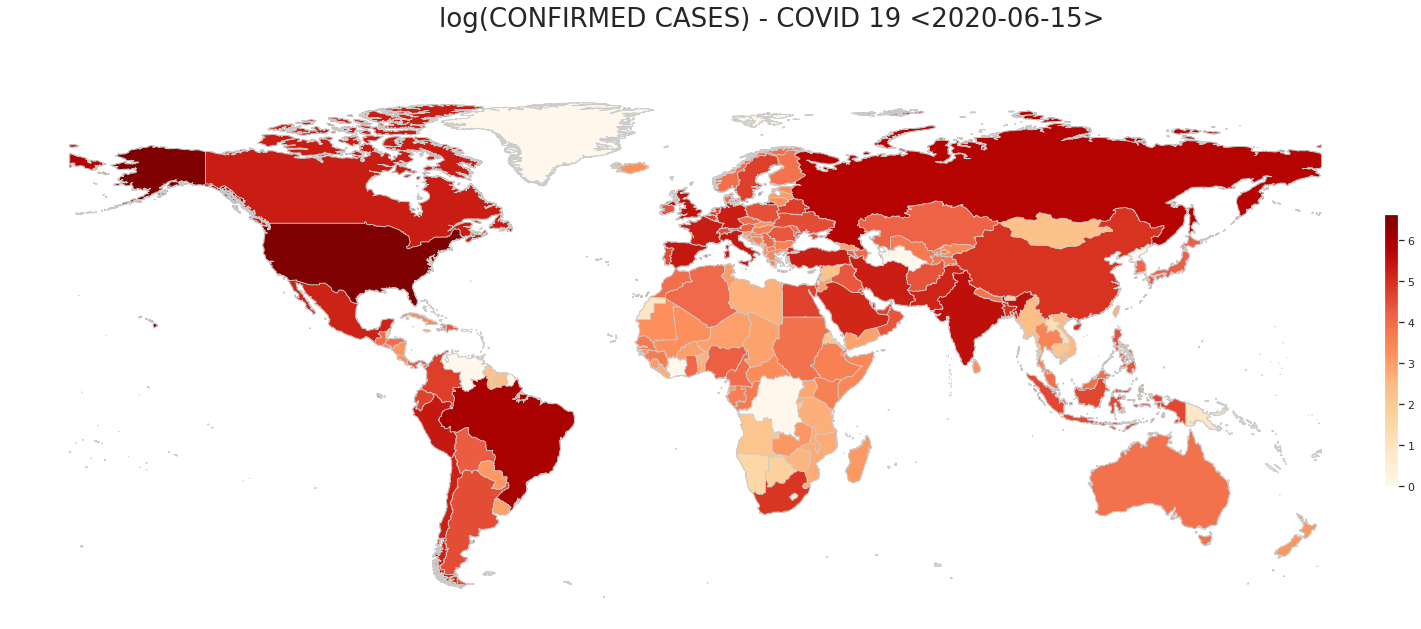

In [ ]:
image_no = 0
vmin, vmax = 0, final.log_Confirmed[final.Date == '2020-06-15'].max()
fig, ax = plt.subplots(1, figsize=(30, 10))
variable = 'log_Confirmed'
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
fig.colorbar(sm, pad = 0.0001, shrink=0.5)


for i in range(0, len(date_list_test)):   
    date_for_mask = date_list_test.Date.values[i]
    mask = (final['Date'] == date_for_mask)
    my_map = final.loc[mask]
    ax.axis('off')
    fig.suptitle('log(CONFIRMED CASES) - COVID 19 <' + str(date_list_test.Date.dt.date.values[i]) + '>', fontsize=26, fontweight = 3)
    my_map.plot(column=variable, cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
    fig.savefig('test_images/WORLD_MAP_{image_no:04d}.png'.format(image_no=image_no), 
                dpi=300, bbox_inches='tight')
    image_no +=1

In [ ]:
# After confirming that the test images are as expected, we can go ahead
# and start plotting the individual maps for each date 

## ---------------------------------------------------------------------------------------
## Plotting the multiple maps for all dates
## ---------------------------------------------------------------------------------------

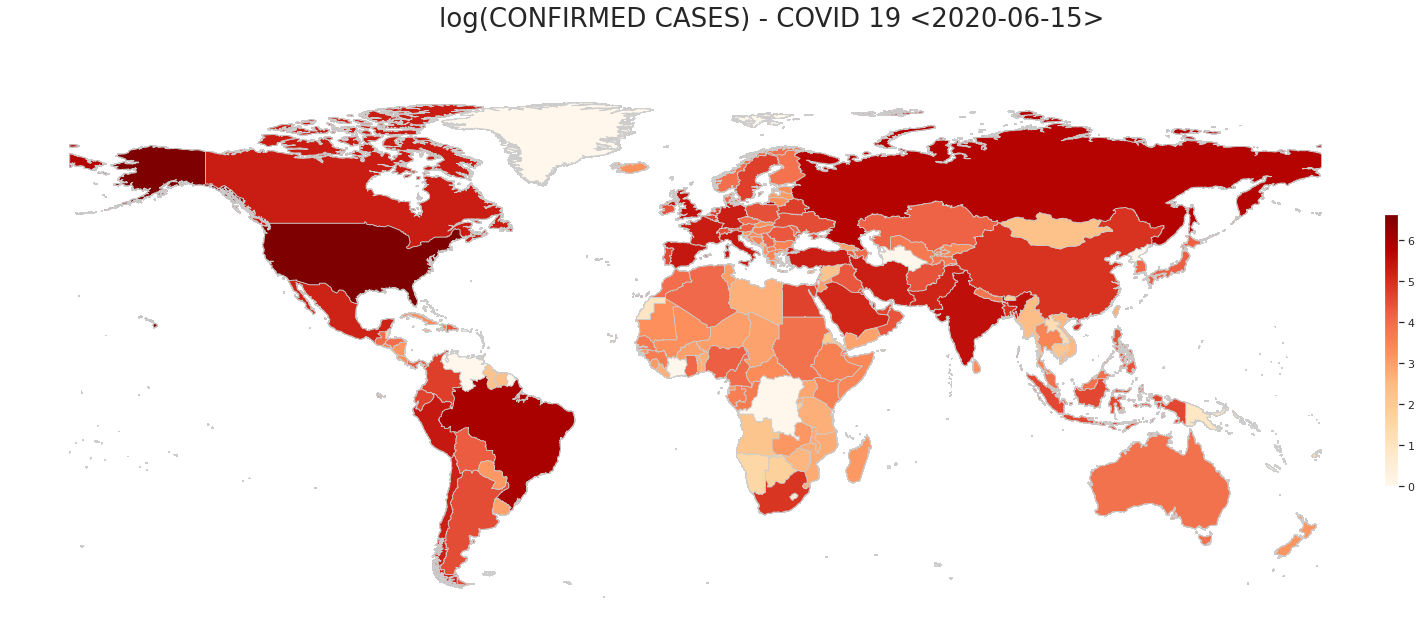

In [ ]:
image_no = 0
vmin, vmax = 0, final.log_Confirmed[final.Date == '2020-06-15'].max()
fig, ax = plt.subplots(1, figsize=(30, 10))
variable = 'log_Confirmed'
sm = plt.cm.ScalarMappable(cmap='OrRd', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
fig.colorbar(sm, pad = 0.0001, shrink=0.5)


for i in range(0, len(date_list)):   
    date_for_mask = date_list.Date.values[i]
    mask = (final['Date'] == date_for_mask)
    my_map = final.loc[mask]
    ax.axis('off')
    fig.suptitle('log(CONFIRMED CASES) - COVID 19 <' + str(date_list.Date.dt.date.values[i]) + '>', fontsize=26, fontweight = 3)
    my_map.plot(column=variable, cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8')
    fig.savefig('images/WORLD_MAP_{image_no:04d}.png'.format(image_no=image_no), 
                dpi=300, bbox_inches='tight')
    image_no +=1

In [ ]:
# Making a video out of all the images
images_path = "images/"
print(os.path.isdir(images_path))
os.system("ffmpeg -f image2 -r 1 -s 1024x768 -i images/WORLD_MAP_%04d.png -vcodec mpeg4 -y videos/video_fr_1.mp4")

0

In [ ]:
# Making a video out of all the images
images_path = "images/"
print(os.path.isdir(images_path))
os.system("ffmpeg -f image2 -r 1/4 -s 1024x768 -i images/WORLD_MAP_%04d.png -vcodec mpeg4 -y videos/video_fr_1_by_4.mp4")

True


0

In [140]:
# Making a video out of all the images
images_path = "images/"
print(os.path.isdir(images_path))
os.system("ffmpeg -f image2 -r 4 -s 1024x768 -i images/WORLD_MAP_%04d.png -vcodec mpeg4 -y videos/video_fr_4.mp4")

True


0

## ---------------------------------------------------------------------------------------
## Downloading the files from Google Colab
## ---------------------------------------------------------------------------------------

In [ ]:
!zip -r file.zip /content

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/.last_survey_prompt.yaml (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2020.06.10/ (stored 0%)
  adding: content/.config/logs/2020.06.10/16.27.46.450102.log (deflated 54%)
  adding: content/.config/logs/2020.06.10/16.28.00.359521.log (deflated 55%)
  adding: content/.config/logs/2020.06.10/16.27.11.187541.log (deflated 92%)
  adding: content/.config/logs/2020.06.10/16.27.42.054200.log (deflated 87%)
  adding: content/.config/logs/2020.06.10/16.27.29.206693.log (deflated 54%)
  adding: content/.config/logs/2020.06.10/16.28

MessageError: ignored

In [ ]:
from google.colab import files
files.download("file.zip")

MessageError: ignored